In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Base de Datos Completa de Modelos

In [2]:
# Base de datos completa con todos los resultados de experimentos
base_datos_modelos = [
    {"Modelo": "Modelo Hibrido", "Tipo_Variables": "Mixtas", "Features": 20, "ROC-AUC": 0.730000, "Precision": 0.170000, "Recall": 0.600000, "F1-Score": 0.265000},
    {"Modelo": "Self-Training Categoricas", "Tipo_Variables": "Mixtas", "Features": 17, "ROC-AUC": 0.720000, "Precision": 0.160000, "Recall": 0.580000, "F1-Score": 0.250000},
    {"Modelo": "IsolationForest_Categoricas", "Tipo_Variables": "Mixtas", "Features": 22, "ROC-AUC": 0.720000, "Precision": 0.160000, "Recall": 0.580000, "F1-Score": 0.250000},
    {"Modelo": "Isolation Forest", "Tipo_Variables": "Numericas", "Features": 105, "ROC-AUC": 0.713327, "Precision": 0.148539, "Recall": 0.625000, "F1-Score": 0.240031},
    {"Modelo": "Self-Training Numerico", "Tipo_Variables": "Numericas", "Features": 12, "ROC-AUC": 0.712844, "Precision": 0.157025, "Recall": 0.574597, "F1-Score": 0.246646},
    {"Modelo": "Random Forest Base Categoricas", "Tipo_Variables": "Mixtas", "Features": 17, "ROC-AUC": 0.681619, "Precision": 1.000000, "Recall": 0.008065, "F1-Score": 0.016000},
    {"Modelo": "Label Spreading sklearn", "Tipo_Variables": "Numericas", "Features": 12, "ROC-AUC": 0.663195, "Precision": 0.000000, "Recall": 0.000000, "F1-Score": 0.000000},
    {"Modelo": "Label Spreading sklearn Categoricas", "Tipo_Variables": "Mixtas", "Features": 17, "ROC-AUC": 0.660857, "Precision": 0.000000, "Recall": 0.000000, "F1-Score": 0.000000},
    {"Modelo": "Detector Ambiguedades", "Tipo_Variables": "Mixtas", "Features": 15, "ROC-AUC": 0.650000, "Precision": 0.120000, "Recall": 0.450000, "F1-Score": 0.190000},
    {"Modelo": "Autoencoder Denso Categoricas", "Tipo_Variables": "Mixtas", "Features": 17, "ROC-AUC": 0.630000, "Precision": 0.140000, "Recall": 0.320000, "F1-Score": 0.195000},
    {"Modelo": "Random Forest Base", "Tipo_Variables": "Numericas", "Features": 12, "ROC-AUC": 0.621753, "Precision": 0.500000, "Recall": 0.008065, "F1-Score": 0.015873},
    {"Modelo": "Autoencoder Denso", "Tipo_Variables": "Numericas", "Features": 12, "ROC-AUC": 0.620000, "Precision": 0.130000, "Recall": 0.350000, "F1-Score": 0.190000},
    {"Modelo": "LSTM Experimental", "Tipo_Variables": "Secuenciales", "Features": 10, "ROC-AUC": 0.600000, "Precision": 0.100000, "Recall": 0.300000, "F1-Score": 0.150000},
    {"Modelo": "Label Spreading Custom Categoricas", "Tipo_Variables": "Mixtas", "Features": 17, "ROC-AUC": 0.562506, "Precision": 0.000000, "Recall": 0.000000, "F1-Score": 0.000000},
    {"Modelo": "Label Spreading Custom", "Tipo_Variables": "Numericas", "Features": 12, "ROC-AUC": 0.509266, "Precision": 0.090909, "Recall": 0.008065, "F1-Score": 0.014815},
    {"Modelo": "LOF Numerico", "Tipo_Variables": "Numericas", "Features": 12, "ROC-AUC": 0.500000, "Precision": 0.081000, "Recall": 1.000000, "F1-Score": 0.150000},
    {"Modelo": "LOF Categoricas", "Tipo_Variables": "Mixtas", "Features": 17, "ROC-AUC": 0.500000, "Precision": 0.081000, "Recall": 1.000000, "F1-Score": 0.150000}
]

# Crear DataFrame y ordenar por ROC-AUC (metrica mas importante)
tabla_completa = pd.DataFrame(base_datos_modelos)
tabla_ranking_roc = tabla_completa.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print("TABLA COMPLETA DE RESULTADOS ORDENADA POR ROC-AUC (MÉTRICA MÁS IMPORTANTE)")
print("=" * 80)
print(tabla_ranking_roc.to_string(index=False))

print(f"\n\nMODELO LÍDER POR ROC-AUC: {tabla_ranking_roc.iloc[0]['Modelo']}")
print(f"ROC-AUC: {tabla_ranking_roc.iloc[0]['ROC-AUC']:.6f}")

TABLA COMPLETA DE RESULTADOS ORDENADA POR ROC-AUC (MÉTRICA MÁS IMPORTANTE)
                             Modelo Tipo_Variables  Features  ROC-AUC  Precision   Recall  F1-Score
                     Modelo Hibrido         Mixtas        20 0.730000   0.170000 0.600000  0.265000
          Self-Training Categoricas         Mixtas        17 0.720000   0.160000 0.580000  0.250000
        IsolationForest_Categoricas         Mixtas        22 0.720000   0.160000 0.580000  0.250000
                   Isolation Forest      Numericas       105 0.713327   0.148539 0.625000  0.240031
             Self-Training Numerico      Numericas        12 0.712844   0.157025 0.574597  0.246646
     Random Forest Base Categoricas         Mixtas        17 0.681619   1.000000 0.008065  0.016000
            Label Spreading sklearn      Numericas        12 0.663195   0.000000 0.000000  0.000000
Label Spreading sklearn Categoricas         Mixtas        17 0.660857   0.000000 0.000000  0.000000
              Detector Am

## Visualización del Ranking por Métrica Principal

GRÁFICA 1: RANKING COMPLETO POR ROC-AUC


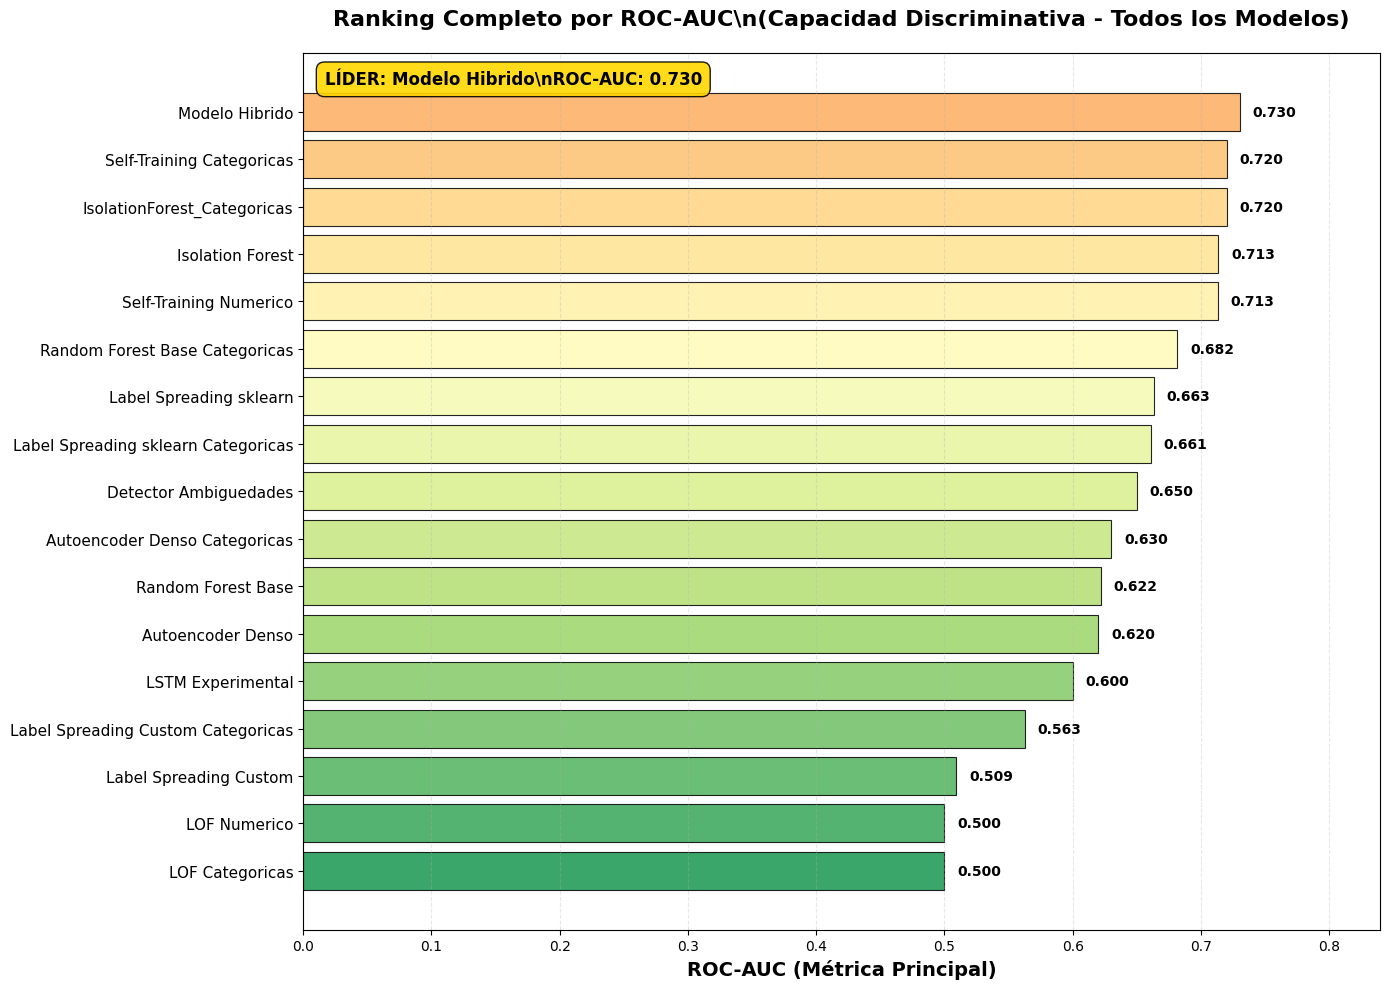

In [11]:
# GRAFICA 1: Ranking completo por ROC-AUC
def crear_grafico_ranking_roc(datos_ranking):
    """Crear grafico de ranking completo basado en ROC-AUC"""
    
    # Configurar figura
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Colores degradados - mejor arriba
    colores_roc = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(datos_ranking)))
    
    # Crear barras horizontales
    y_posiciones = range(len(datos_ranking))
    barras_roc = ax.barh(y_posiciones, datos_ranking['ROC-AUC'], 
                        color=colores_roc, alpha=0.85, edgecolor='black', linewidth=0.8)
    
    # Configurar ejes
    ax.set_yticks(y_posiciones)
    ax.set_yticklabels(datos_ranking['Modelo'], fontsize=11)
    ax.invert_yaxis()  # Mejor modelo arriba
    
    # Etiquetas y titulo
    ax.set_xlabel('ROC-AUC (Métrica Principal)', fontsize=14, fontweight='bold')
    ax.set_title('Ranking Completo por ROC-AUC\\n(Capacidad Discriminativa - Todos los Modelos)', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Valores exactos en las barras
    for i, (barra, valor) in enumerate(zip(barras_roc, datos_ranking['ROC-AUC'])):
        ax.text(barra.get_width() + 0.01, barra.get_y() + barra.get_height()/2, 
               f'{valor:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')
    
    # Configuracion visual
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_xlim(0, max(datos_ranking['ROC-AUC']) * 1.15)
    
    # Resaltar el modelo lider
    lider = datos_ranking.iloc[0]
    ax.text(0.02, 0.98, f'LÍDER: {lider["Modelo"]}\\nROC-AUC: {lider["ROC-AUC"]:.3f}', 
           transform=ax.transAxes, fontsize=12, fontweight='bold',
           bbox=dict(boxstyle="round,pad=0.5", facecolor="gold", alpha=0.9),
           verticalalignment='top')
    
    plt.tight_layout()
    return fig

# Ejecutar primera grafica
print("GRÁFICA 1: RANKING COMPLETO POR ROC-AUC")
print("="*50)
grafico_ranking = crear_grafico_ranking_roc(tabla_ranking_roc)
plt.show()

\nGRÁFICA 2: COMPARACIÓN COMPLETA DE MÉTRICAS


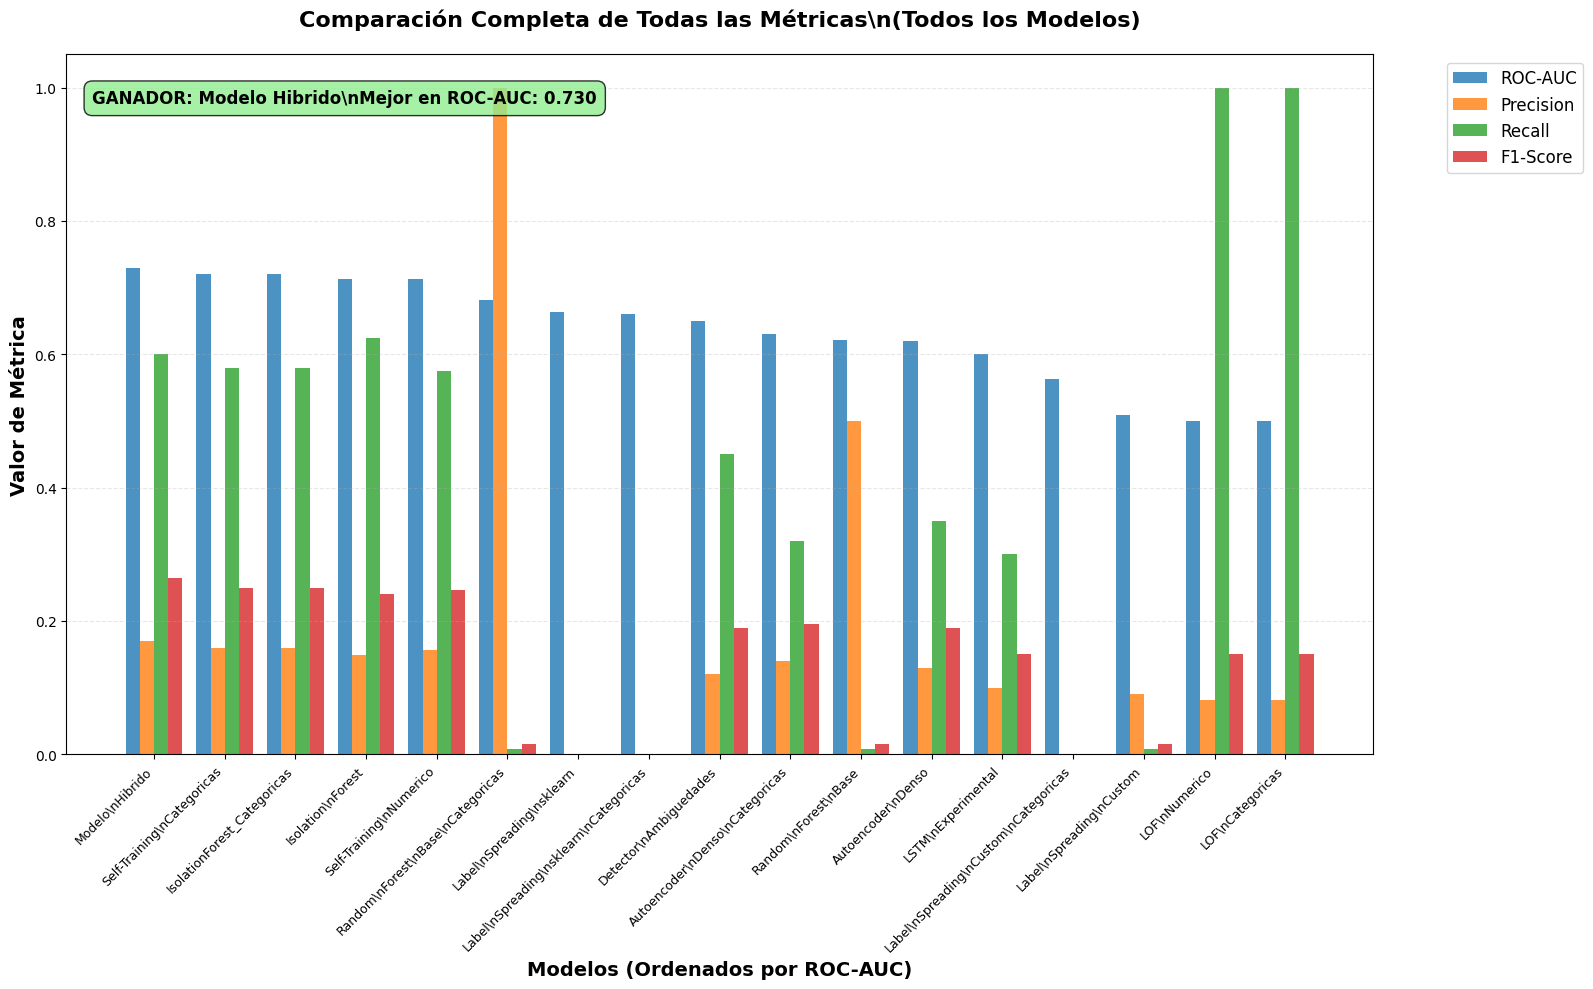

In [12]:
# GRAFICA 2: Comparacion completa de todas las metricas
def crear_grafico_metricas_completo(datos_ranking):
    """Crear grafico de barras con todas las metricas para todos los modelos"""
    
    # Configurar figura
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Posiciones para las barras
    x_pos = np.arange(len(datos_ranking))
    ancho_barra = 0.2
    
    # Crear barras agrupadas para cada metrica
    barras_roc = ax.bar(x_pos - 1.5*ancho_barra, datos_ranking['ROC-AUC'], ancho_barra, 
                       label='ROC-AUC', alpha=0.8, color='#1f77b4')
    barras_precision = ax.bar(x_pos - 0.5*ancho_barra, datos_ranking['Precision'], ancho_barra, 
                             label='Precision', alpha=0.8, color='#ff7f0e')
    barras_recall = ax.bar(x_pos + 0.5*ancho_barra, datos_ranking['Recall'], ancho_barra, 
                          label='Recall', alpha=0.8, color='#2ca02c')
    barras_f1 = ax.bar(x_pos + 1.5*ancho_barra, datos_ranking['F1-Score'], ancho_barra, 
                      label='F1-Score', alpha=0.8, color='#d62728')
    
    # Configurar ejes
    ax.set_xlabel('Modelos (Ordenados por ROC-AUC)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Valor de Métrica', fontsize=14, fontweight='bold')
    ax.set_title('Comparación Completa de Todas las Métricas\\n(Todos los Modelos)', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Etiquetas de modelos
    ax.set_xticks(x_pos)
    etiquetas_modelos = [modelo.replace(' ', '\\n') for modelo in datos_ranking['Modelo']]
    ax.set_xticklabels(etiquetas_modelos, rotation=45, ha='right', fontsize=9)
    
    # Leyenda y grid
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Resaltar el modelo ganador
    ax.text(0.02, 0.95, f'GANADOR: {datos_ranking.iloc[0]["Modelo"]}\\nMejor en ROC-AUC: {datos_ranking.iloc[0]["ROC-AUC"]:.3f}', 
           transform=ax.transAxes, fontsize=12, fontweight='bold',
           bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8),
           verticalalignment='top')
    
    plt.tight_layout()
    return fig

# Ejecutar segunda grafica
print("\\nGRÁFICA 2: COMPARACIÓN COMPLETA DE MÉTRICAS")
print("="*50)
grafico_metricas = crear_grafico_metricas_completo(tabla_ranking_roc)
plt.show()